# **Monitoring Activation Stats**

This NB will focus on building functionality to allow the monitoring of activation stats during the modelling process. Thus allowing us to diagnose issues during both training and inference, by actually looking _inside_ the models.

In [1]:
from __future__ import annotations
import random,math,torch
import numpy as np
import matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [2]:
import torch.nn.functional as F
import matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

To enable reproducibility, especially for the context of modelling on a single machine, we will use PyTorch's `use_deterministic_algorithms` flag.

In [3]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

## **Get Data**

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

## **Create a Baseline Model**

In [5]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We'll be training at a higher learning rate not only to save time, but also to find a more generalizable set of weights. Jeremy also says that training at a higher learning rate ensures "stable training". **This is something I need to dig into**

In [6]:
from torcheval.metrics import MulticlassAccuracy

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [12]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.157,2.299,0,train
0.198,2.114,0,eval


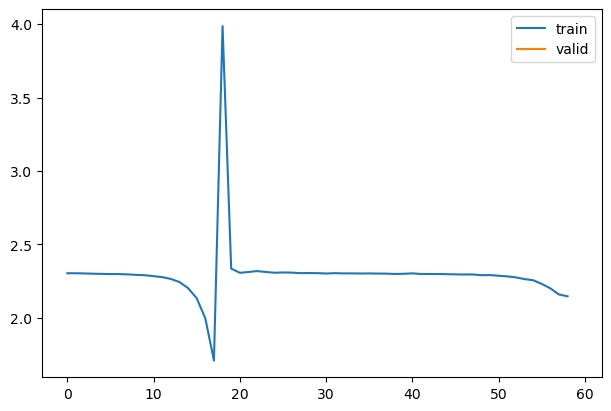

In [13]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

Clearly the model's training process isn't off to a good start. This means there has to be something wrong with our initial activations. Time to build some functionality which allows us to look into the different layers of the model.

## **Using Hooks**

### **Manual Insertion**

In [16]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) # covered in earlier nbs
        # Taking the means and std of the activations
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds[i].append(to_cpu(x).std())
        return x

    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
0.161,2.297,0,train
0.325,1.914,0,eval


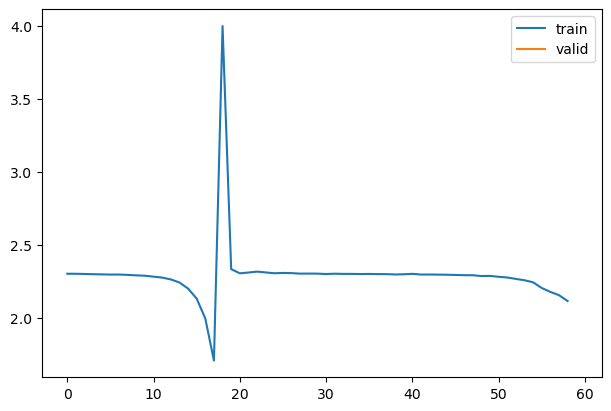

In [17]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

Now we can plot the activation means, for each batch, broken out by individual layers.

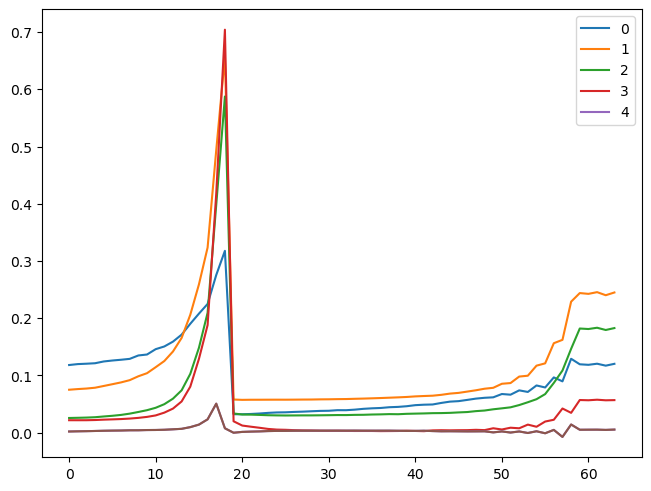

In [18]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

The same for standard deviations.

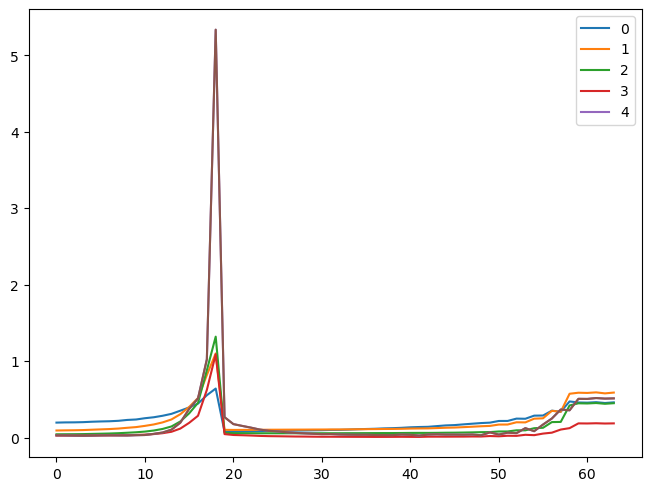

In [19]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

If activations don't follow the general rule of having their means close to 0 and standard deviations close to one - that usually indicates that we have dead neurons with failed activations.

So, our model has failed before it even began to train for increased epochs.

### **PyTorch Hooks**

> Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [20]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We will still need to track the activations means and standard deviations. Since the hook is attached to a layer and takes three arguments, i.e. module, input, output, we will need to store the mean and std of the _output_ in the correct position of our list.

In [21]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [24]:
def append_stats(i, mod, inp, outp): # Function called by the hook, where i is the layer number
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [25]:
for i, m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.157,2.300,0,train
0.250,2.109,0,eval


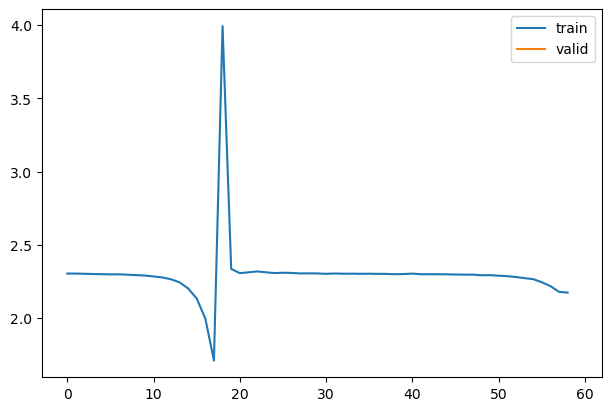

In [26]:
fit(model)

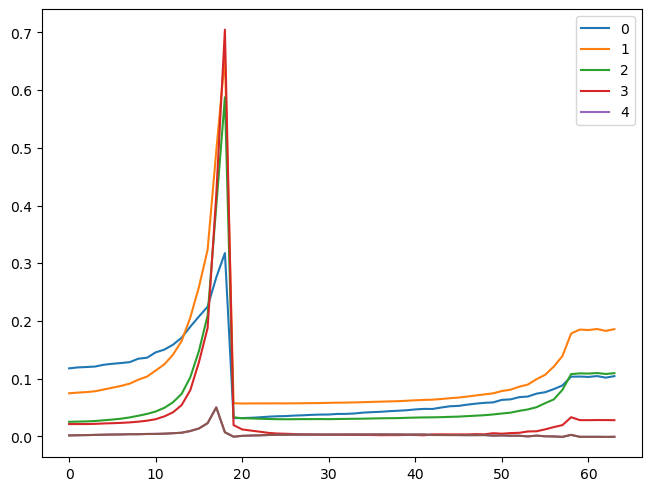

In [27]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### **A Hooks Class**
#### **Demo**

In [33]:
# for demo purposes
class DummyCtxMgr():
    def __enter__(self, *args):
        print("Starting Up!")
        return self
    
    def __exit__(self, *args): print("Wrapping up!")

    def hello(self): print("Ola!")

In [34]:
with DummyCtxMgr() as dcm: dcm.hello()

Starting Up!
Ola!
Wrapping up!


In [35]:
# Still for demos
class DummyList(list):
    def __delitem__(self, i):
        print(f"Dropping item {i}")
        super().__delitem__(i)

In [36]:
dml = DummyList([1, 3, 2])
dml

[1, 3, 2]

In [38]:
# Delete item by index
del(dml[1])
dml

Dropping item 1


[1, 2]